In [2]:
# Import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc
import seaborn as sns
import warnings
from scipy.stats import f_oneway
from scipy import stats
from scipy.stats import levene
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.graphics.factorplots import interaction_plot
# Ignore the warnings
warnings.filterwarnings("ignore")

In [7]:
# Import the dataset
arrest_data = pd.read_csv("Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv")

In [8]:
# Data manipulation and clean up
# Add the num_arrests column to the DataFrame
count = arrest_data.groupby("PersonID")["PersonID"].transform("count")
arrest_data["num_arrests"] = count

# Create a new column indicating whether each person is a youth or an adult
arrest_data.loc[arrest_data['Youth_at_arrest__under_18_years'] == 'Not a youth', 'Age_group'] = 'Adult'
arrest_data.loc[
    arrest_data['Youth_at_arrest__under_18_years'] == 'Youth (aged 17 and younger)', 'Age_group'] = 'Youth'
arrest_data.loc[
    arrest_data['Youth_at_arrest__under_18_years'] == 'Youth (aged 17 years and under)', 'Age_group'] = 'Youth'

# Group the data by age group and count the number of arrests for each group
grouped = arrest_data.groupby("Age_group")["num_arrests"]
youth_arrests = grouped.get_group("Youth").values
adult_arrests = grouped.get_group("Adult").values

# Create a new column indicating whether each person is Male or Female
arrest_data.loc[arrest_data['Sex'] == 'M', 'Gender'] = 'Male'
arrest_data.loc[arrest_data['Sex'] == 'F', 'Gender'] = 'Female'

# Group the data by gender and count the number of arrests for each group
grouped_1 = arrest_data.groupby("Gender")["num_arrests"]
Male_arrests = grouped_1.get_group("Male").values
Female_arrests = grouped_1.get_group("Female").values

# Adult mean arrest
print("Adult mean: ", np.mean(adult_arrests), "std: ", np.std(adult_arrests))
# Youth mean arrest
print("Youth mean: ", np.mean(youth_arrests), "std: ", np.std(youth_arrests))
# Male mean arrest
print("Male mean: ", np.mean(Male_arrests), "std: ", np.std(Male_arrests))
# Female mean arrest
print("Feamle mean: ", np.mean(Female_arrests), "std: ", np.std(Female_arrests))
    
# Create a new column indicating whether which quarter the arrest event happened
arrest_data.loc[arrest_data['Arrest_Month'] == 'Jan-Mar', 'Quarter'] = 'Q1'
arrest_data.loc[arrest_data['Arrest_Month'] == 'Apr-June', 'Quarter'] = 'Q2'
arrest_data.loc[arrest_data['Arrest_Month'] == 'July-Sept', 'Quarter'] = 'Q3'
arrest_data.loc[arrest_data['Arrest_Month'] == 'Oct-Dec', 'Quarter'] = 'Q4'

# Group the data by the quarter of each arrest event and count the number of arrests for each group
grouped_2 = arrest_data.groupby("Quarter")["num_arrests"]
Q1_arrests = grouped_2.get_group("Q1").values
Q2_arrests = grouped_2.get_group("Q2").values
Q3_arrests = grouped_2.get_group("Q1").values
Q4_arrests = grouped_2.get_group("Q1").values

Adult mean:  4.2074268084969635 std:  5.48272832778257
Youth mean:  2.6124260355029585 std:  2.99572620714437
Male mean:  4.186799620132954 std:  5.496668810305047
Feamle mean:  3.909328683522232 std:  4.987265005848697


In [10]:
# After the data cleaning, create a new dataframe for further analysis
new_df = arrest_data[['Arrest_Year', 'PersonID', 'num_arrests', 'Gender', 'Age_group', 'Quarter', 'ArrestLocDiv',
                          'StripSearch', 'Booked', 'Occurrence_Category']]

# Drop the null value
new_df = new_df.dropna()

# Data Overview
print(new_df.head())
print(new_df.describe())  # Data Description
print(new_df.dtypes)  # Check data type
print(new_df.isnull().sum())  # Check the null value

# Test normality of dataset by using Shapiro-Wilk test
statistics, p_value = stats.shapiro(new_df["num_arrests"])
# Print the p-value
print("Shapiro-Wilk test statistic:", statistics)
print(f"p-value: {p_value:.20f}")
# interpret the results
if p_value > 0.05: print("The dataset is normally distributed.")
else: print("The dataset is not normally distributed.")

# Homogeneity of variances assumption test for RQ1
statistic, p_value = stats.levene(*[np.array(new_df['num_arrests'])[(np.array(new_df['Quarter']) == quarter)]
                                    for quarter in np.unique(new_df['Quarter'])])
# print the results
print('Levene test statistic: {:.4f}'.format(statistic))
print('p-value: {:.10f}'.format(p_value))

# Homogeneity of variances assumption test for RQ2
statistic, p_value = stats.levene(*[np.array(new_df['num_arrests'])[(np.array(new_df['Age_group']) == group) & (np.array(new_df['Gender']) == Gender)] 
                                    for group in np.unique(new_df['Age_group']) for Gender in np.unique(new_df['Gender'])])
# print the results
print('Levene test statistic: {:.4f}'.format(statistic))
print('p-value: {:.100f}'.format(p_value))

   Arrest_Year  PersonID  num_arrests Gender Age_group Quarter ArrestLocDiv  \
0         2020    326622            3   Male     Adult      Q3           54   
1         2020    326622            3   Male     Adult      Q3           54   
2         2020    326622            3   Male     Adult      Q4           54   
3         2021    327535            3   Male     Adult      Q1           XX   
4         2021    327535            3   Male     Adult      Q1           XX   

   StripSearch  Booked                     Occurrence_Category  
0            0       1  Assault & Other crimes against persons  
1            0       1  Assault & Other crimes against persons  
2            0       1  Assault & Other crimes against persons  
3            0       0                  Harassment/Threatening  
4            0       1       FTA/FTC/Compliance Check/Parollee  
        Arrest_Year       PersonID   num_arrests   StripSearch        Booked
count  65102.000000   65102.000000  65102.000000  65102.00

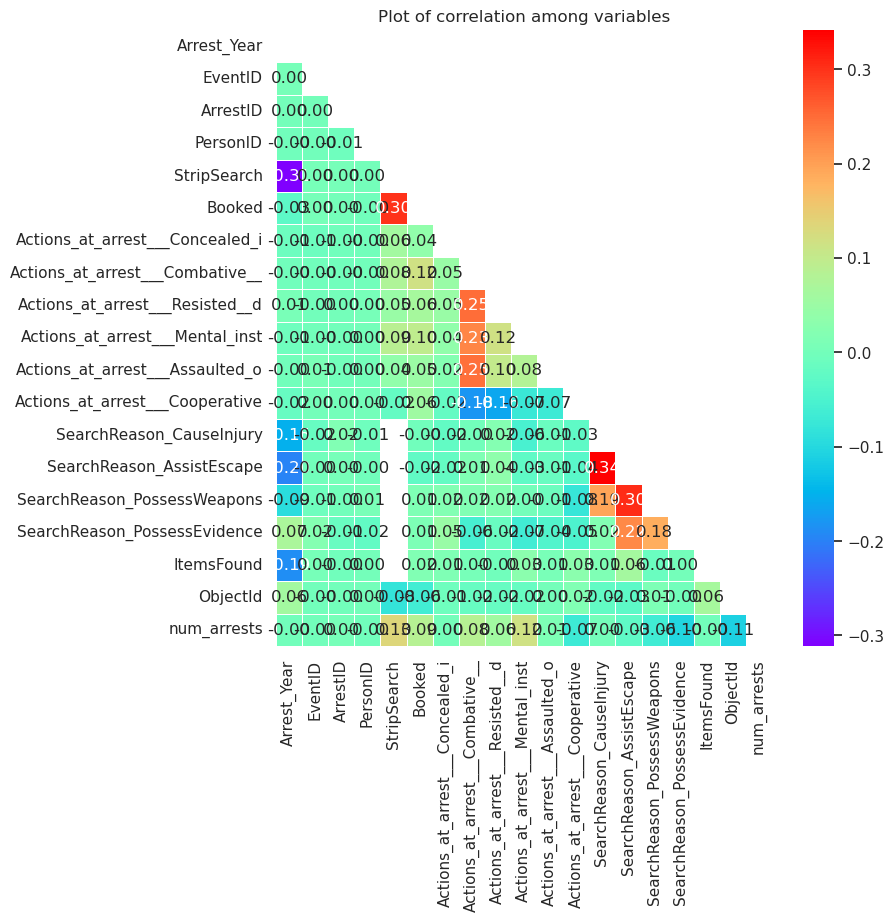

In [65]:
# Data Visualization
# Check the collinearity among each variable
corr = arrest_data.corr()
fig, ax = plt.subplots(figsize=(8, 8))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(corr, cmap="rainbow", linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.title("Plot of correlation among variables")
plt.show()

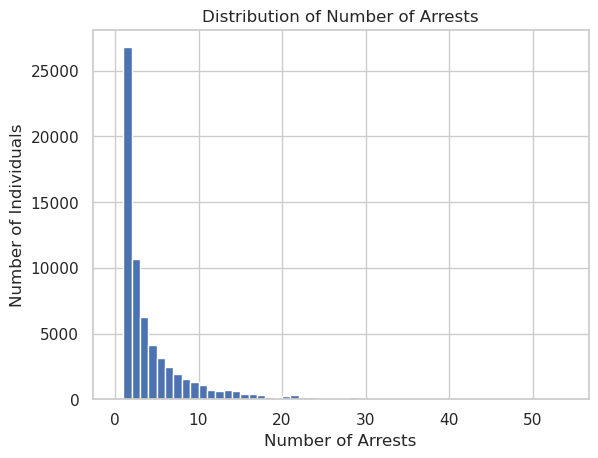

In [66]:
# Plot the distribution num_arrests
plt.hist(arrest_data["num_arrests"], bins=range(0, max(arrest_data["num_arrests"]) + 1))

# Add labels and title to the plot
plt.xlabel("Number of Arrests")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Number of Arrests")
plt.show()

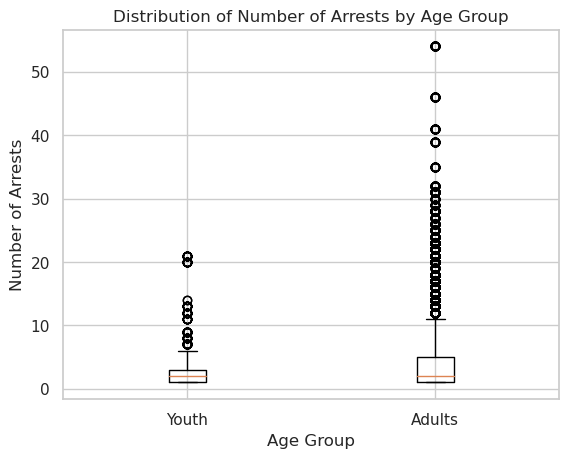

In [67]:
# Create a box plot of the number of arrests committed by youth and adults
plt.boxplot([new_df[new_df["Age_group"] == "Youth"]["num_arrests"],
            new_df[new_df["Age_group"] == "Adult"]["num_arrests"]],
            labels=["Youth", "Adults"])

# Add labels and title
plt.xlabel("Age Group")
plt.ylabel("Number of Arrests")
plt.title("Distribution of Number of Arrests by Age Group")
plt.show()

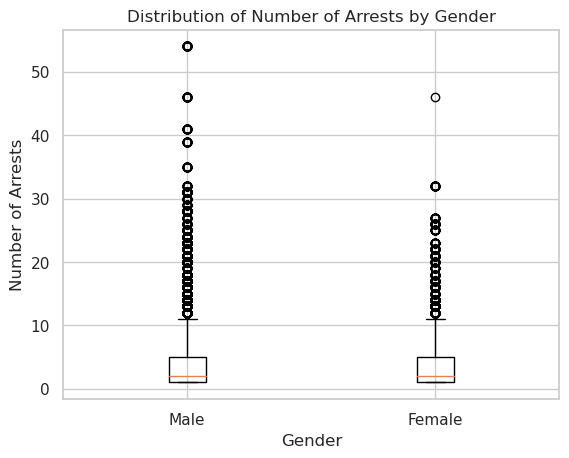

In [68]:
# Create a box plot of the number of arrests committed by youth and adults
plt.boxplot([new_df[new_df["Gender"] == "Male"]["num_arrests"],
            new_df[new_df["Gender"] == "Female"]["num_arrests"]],
            labels=["Male", "Female"])

# Add labels and title
plt.xlabel("Gender")
plt.ylabel("Number of Arrests")
plt.title("Distribution of Number of Arrests by Gender")
plt.show()

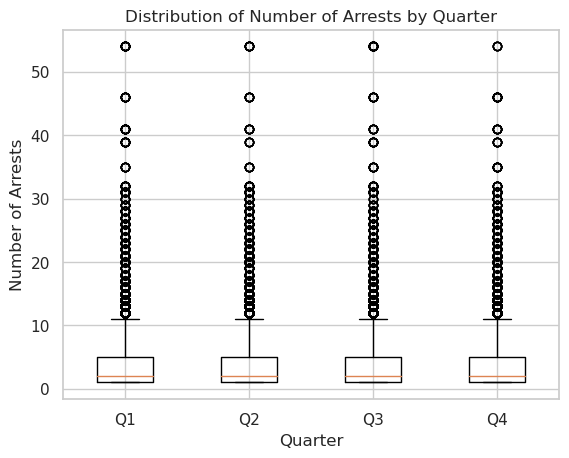

In [69]:
# Create a box plot of the number of arrests committed by quarter
plt.boxplot([new_df[new_df["Quarter"] == "Q1"]["num_arrests"],
            new_df[new_df["Quarter"] == "Q2"]["num_arrests"],
            new_df[new_df["Quarter"] == "Q3"]["num_arrests"],
            new_df[new_df["Quarter"] == "Q4"]["num_arrests"]],
            labels=["Q1", "Q2", "Q3", "Q4"])

# Add labels and title
plt.xlabel("Quarter")
plt.ylabel("Number of Arrests")
plt.title("Distribution of Number of Arrests by Quarter")
plt.show()

In [70]:
# Perform the t-test
# Whether there is a significant difference in mean numbers of crime committed between youth and adult
t_statistic, p_value = stats.ttest_ind(youth_arrests, adult_arrests)

# Print the results
print("t-statistic: ", t_statistic)
print("p-value: ", p_value)

# Whether there is a significant difference in mean numbers of crime committed between male and female
t_statistic, p_value = stats.ttest_ind(Male_arrests, Female_arrests)

# Print the results
print("t-statistic: ", t_statistic)
print("p-value: ", p_value)

t-statistic:  -15.929098884448198
p-value:  5.100280677807055e-57
t-statistic:  5.1819286475425415
p-value:  2.202550954987065e-07


In [71]:
# Conduct the one-way Anova test for RQ1
f_value, p_value = f_oneway(Q1_arrests, Q2_arrests, Q3_arrests, Q4_arrests)

# print the results
print("F-value:", f_value)
print("P-value:", p_value)

# Conduct Tukey's HSD post-hoc test
tk_model2 = mc.pairwise_tukeyhsd(endog=new_df['num_arrests'], groups=new_df['Quarter'],
                                     alpha=0.05)
print(tk_model2.summary())

F-value: 1.0331748857104663
P-value: 0.37654065330901476
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    Q1     Q2   0.0902 0.4341 -0.0637   0.244  False
    Q1     Q3  -0.0376 0.9177 -0.1874  0.1123  False
    Q1     Q4   -0.103 0.3066 -0.2557  0.0497  False
    Q2     Q3  -0.1277 0.1504 -0.2834  0.0279  False
    Q2     Q4  -0.1932 0.0094 -0.3515 -0.0348   True
    Q3     Q4  -0.0654 0.6969   -0.22  0.0891  False
----------------------------------------------------


                        sum_sq       df           F        PR(>F)
Age_group         7.221355e+03      1.0  248.265632  7.868940e-56
Gender            6.514733e+02      1.0   22.397243  2.221570e-06
Age_group:Gender  1.678232e+02      1.0    5.769656  1.630801e-02
Residual          1.893519e+06  65098.0         NaN           NaN
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
AdultFemale   AdultMale   0.2844    0.0  0.1429  0.4259   True
AdultFemale YouthFemale  -1.1509    0.0 -1.6786 -0.6232   True
AdultFemale   YouthMale   -1.432    0.0 -1.7477 -1.1162   True
  AdultMale YouthFemale  -1.4352    0.0 -1.9511 -0.9194   True
  AdultMale   YouthMale  -1.7163    0.0 -2.0119 -1.4208   True
YouthFemale   YouthMale  -0.2811 0.6089 -0.8691  0.3069  False
--------------------------------------------------------------


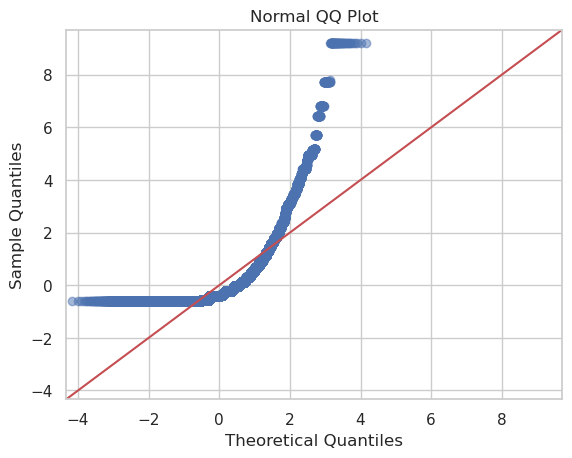

In [72]:
# Conduct the two-way Anova test for RQ2
model = smf.ols('num_arrests ~ Age_group + Gender + Age_group:Gender', data=new_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)

# Conduct Tukey's HSD post-hoc test
tk_model1 = mc.pairwise_tukeyhsd(endog=new_df['num_arrests'], groups=new_df['Age_group'] + new_df['Gender'],
                                     alpha=0.05)
print(tk_model1.summary())

# Normal QQ plot
residuals = model.resid
qq_plot = ProbPlot(residuals, fit=True)
qq_plot.qqplot(line='45', alpha=0.5)
plt.title('Normal QQ Plot')
plt.show()

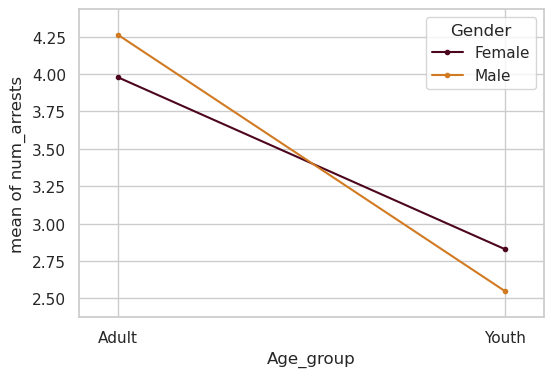

In [73]:
fig, ax = plt.subplots(figsize=(6,4))
interaction_plot(x=new_df['Age_group'], trace=new_df['Gender'], response=new_df['num_arrests'], 
    colors=['#4c061d','#d17a22'], ax = ax)
plt.show()